In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = []
list = [pd.read_json(filename, lines=True) for filename in glob.glob("../week4/data/return-data/*.txt")]
df = pd.concat(list, axis=0)
df.head()

,basket,returnLabel,totalAmount,transactionId,zipCode
0,"[3, 1]",0,106,3520406327,7667
1,[1],0,50,6030070379,7647
2,"[1, 1, 5, 4, 1]",0,175,6579182382,2633
3,"[1, 2, 0, 1]",0,272,2779338441,4309
4,[2],0,14,3198368336,4659


In [4]:
df.drop(['transactionId','zipCode'],axis=1,inplace=True)
df.head()

,basket,returnLabel,totalAmount
0,"[3, 1]",0,106
1,[1],0,50
2,"[1, 1, 5, 4, 1]",0,175
3,"[1, 2, 0, 1]",0,272
4,[2],0,14


In [5]:
def categories(c, value):
    return c.count(value)

df['c_0'] = df['basket'].apply(lambda x: categories(x, 0))
df['c_1'] = df['basket'].apply(lambda x: categories(x, 1))
df['c_2'] = df['basket'].apply(lambda x: categories(x, 2))
df['c_3'] = df['basket'].apply(lambda x: categories(x, 3))
df['c_4'] = df['basket'].apply(lambda x: categories(x, 4))
df['c_5'] = df['basket'].apply(lambda x: categories(x, 5))

df.drop(['basket'],axis=1,inplace=True)

df.head()

,returnLabel,totalAmount,c_0,c_1,c_2,c_3,c_4,c_5
0,0,106,0,1,0,1,0,0
1,0,50,0,1,0,0,0,0
2,0,175,0,3,0,0,1,1
3,0,272,1,2,1,0,0,0
4,0,14,0,0,1,0,0,0


In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(['returnLabel'],axis=1)
y = df['returnLabel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50,random_state=0)

## Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [8]:
logmodelpredictions = logmodel.predict_proba(X_test)
logmodelpredictions = logmodelpredictions[:, 1]
logmodelpredictions

array([1.96898178e-04, 2.90046390e-05, 4.92746391e-04, ...,
       1.58862607e-04, 2.34652247e-02, 1.96098318e-04])

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=10, n_estimators=20)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
forestpredictions = forest.predict_proba(X_test)
forestpredictions = forestpredictions[:, 1]
forestpredictions

array([0.       , 0.       , 0.       , ..., 0.       , 0.0175803,
       0.       ])

## Preparing dataframes function

In [11]:
def get_df(ytest, predictions):
    df = pd.DataFrame({'value':ytest.index, 'true_data':ytest.values})
    df = df.assign(prediction = predictions)
    df.sort_values(["prediction", "value"], inplace=True, ascending=False)
    df = df.reset_index(drop=True)
    return df

## ROC functions

In [12]:
def get_thresholds(data):
    predictions = data.drop_duplicates("prediction")
    predictions = predictions["prediction"].reset_index(drop=True)
    thresholds = []
    thresholds.append(max(predictions) + 1)
    
    for i in range(len(predictions)):
        thresholds.append(predictions[i])

    thresholds.sort()
    thresholds.reverse()
    
    return thresholds

In [13]:
def get_rates(data):
    tpr = []
    fpr = []
    
    thresholds = get_thresholds(data)

    for j in range(len(thresholds)):
        tn = 0
        fp = 0
        fn = 0
        tp = 0
        
        over_threshold = data.loc[data['prediction'] >= thresholds[j], 'true_data'].count()
        under_threshold = data.loc[data['prediction'] < thresholds[j], 'true_data'].count()
        
        tp = data.loc[data['prediction'] >= thresholds[j], 'true_data'].sum()
        fn = data.loc[data['prediction'] < thresholds[j], 'true_data'].sum()
        
        fp = over_threshold - tp
        tn = under_threshold - fn
        
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))

    return [tpr, fpr]

In [14]:
def plot_roc(ytest, predictions):
    plt.figure()
    lw = 2
    plt.title('Receiver Operating Characteristic')
    
    for i in range(len(predictions)):
        rates = get_rates(get_df(ytest, predictions[i][0]))
        plt.plot(rates[1], rates[0], color=predictions[i][1],
                 lw=lw, linestyle=':', label=predictions[i][2])
        
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

## Plot ROC curves

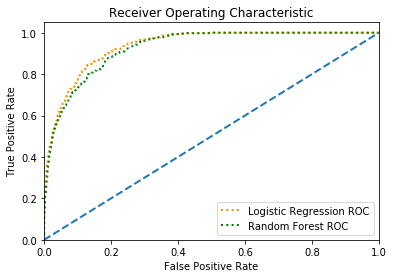

In [15]:
plot_roc(y_test,
         [[logmodelpredictions, 'darkorange', 'Logistic Regression ROC'],
          [forestpredictions, 'green', 'Random Forest ROC']])